# Crab Age Regression

## Define Problem:
This is a regression problem that's created as a [Kaggle competition](https://www.kaggle.com/competitions/playground-series-s3e16/overview). 

## Data to Use:
The dataset to use is supplied by the [Kaggle Playground Prediction Competition](https://www.kaggle.com/competitions/playground-series-s3e16/data).

In this data contains:
- test.csv
- train.csv

## Evaluation Metrics:
The submission will be evaluated using the Mean Absolute Error (MAE). 

The submission format should be in the following style:
> For each id in the test set, you must predict the target Age. The file should contain a header and have the following format:

    id,yield
    74051,10.2
    74051,3.6
    74051,11.9
    etc.


## Features to Use:

    sex: I, M, F (categorical)
    length: float
    diameter: float
    height: float
    weight: float
    shucked weight: float
    viscera weight: float
    shell weight: float
    age: int


## Import Libraries

In [113]:
import glob, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# preprocess
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# evaluation
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load Data

In [4]:
files = glob.glob("data/crab_age.zip")

for file in files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/crab_age_raw')

In [38]:
# Load datasets
train_df = pd.read_csv("data/crab_age_raw/train.csv")
test_df = pd.read_csv("data/crab_age_raw/test.csv")

## EDA

In [39]:
print(train_df.head())
print(len(train_df))

   id Sex  Length  Diameter  Height     Weight  Shucked Weight   
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926  \
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  
74051


These seem to be the following feature attributes:
- sex: I, M, F (categorical)
- length: float 
- diameter: float
- height: float
- weight: float
- shucked weight: float
- viscera weight: float
- shell weight: float
- age: int 

### Missing Values Analysis

In [40]:
train_df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


### Feature Distributions

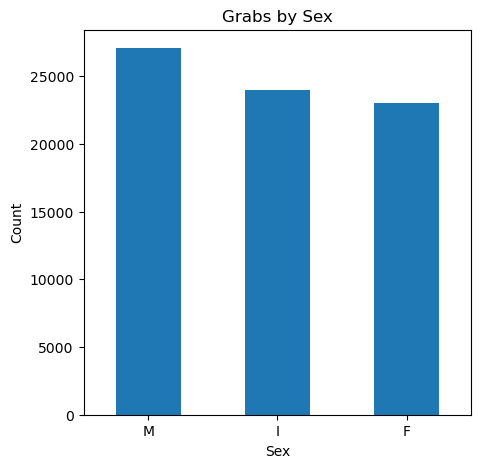

In [42]:
train_df["Sex"].value_counts().plot.bar(figsize=(5, 5))
plt.title("Grabs by Sex")
plt.xticks(rotation=0)
plt.xlabel("Sex")
plt.ylabel("Count");

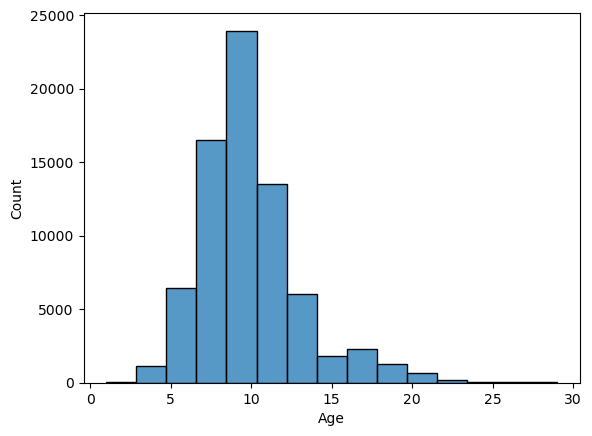

In [50]:
sns.histplot(train_df['Age'], bins=15, kde=False)
plt.show()

The histogram seems to have a right-tail skew. With most people crabs with age 10.

### Outlier Detection

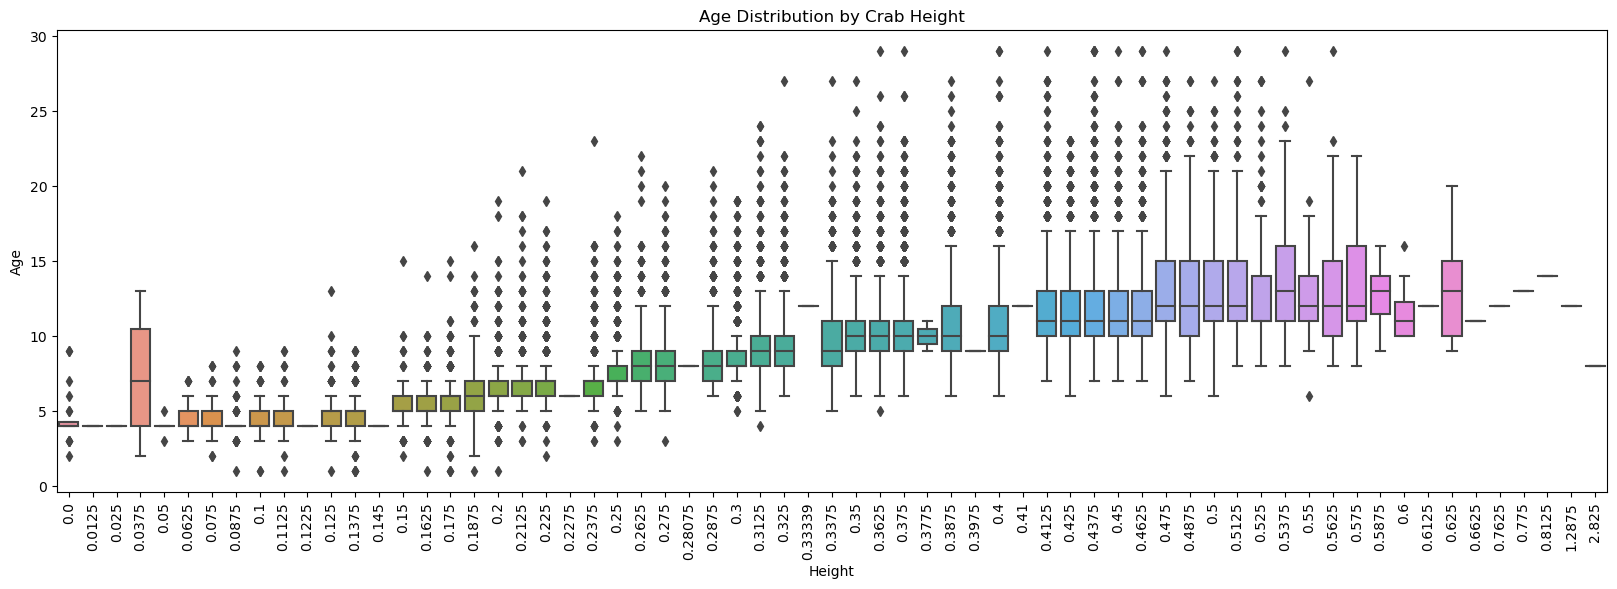

In [51]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=train_df, x='Height', y='Age')
plt.title("Age Distribution by Crab Height")
plt.xlabel("Height")
plt.ylabel("Age")
plt.xticks(rotation=90)
plt.show()

Based on the boxplot of the height disitrbution by age, there seems to be a lot of outliers for a lot of those crabs with different heights. 

## Clean Data

- Just for my personal preference, I'm going to lower case the column names. 

In [52]:
train_df.columns = train_df.columns.str.lower()
train_df.head()

,id,sex,length,diameter,height,weight,shucked weight,viscera weight,shell weight,age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [53]:
train_df.drop("id", axis=1, inplace=True)
train_df

,sex,length,diameter,height,weight,shucked weight,viscera weight,shell weight,age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


## Preprocess

- Normalize the numerical vlaues
- OHE categorical values

In [56]:
categorical_features = ["sex"]
categorical_transformer = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

numerical_features = [
    "length",
    "diameter",
    "height",
    "weight",
    "shucked weight",
    "viscera weight",
    "shell weight"
]
numerical_transformer = Pipeline(steps=[("minmaxscaler", MinMaxScaler(feature_range=(0, 1)))])

preprocessor = ColumnTransformer(transformers=[
    ("categorical", categorical_transformer, categorical_features),
    ("numerical", numerical_transformer, numerical_features)
])

## Split train/val/test 

In [64]:
X = train_df.drop("age", axis=1)
y = train_df["age"]

NUM_IMAGES = 5000

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(59240, 14811, 59240, 14811)

## Build Model(s)

In [168]:
metrics = {}

In [176]:
def combine_model_metrics_to_main_df(metrics):
    main_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score", "MAE", "MSE", "R_squared", "Fit_time"])
    return main_df

In [178]:
def add_train_metrics(model, model_name, X_test, y_test, fit_time):
    y_preds = model.predict(X_test)
    metrics[model_name] = [
        model.score(X_test, y_test),
        mean_absolute_error(y_test, y_preds),
        mean_squared_error(y_test, y_preds),
        r2_score(y_test, y_preds),
        fit_time
    ]
    return metrics

In [179]:
def show_cv_metrics(model, model_name):
    metrics = {
        "MAE": model["test_neg_mean_absolute_error"],
        "MSE": model["test_neg_mean_squared_error"],
        "R_squared": model["test_r2"],
        "Fit_time": model["fit_time"]
    }
    return metrics

In [180]:
def fit_and_eval(estimator, model_name, X_train, y_train, X_test, y_test):
    start = time.time()
    model = Pipeline(steps = [
        ("preprocessor", preprocessor),
        ("model", estimator)
    ])

    model.fit(X_train, y_train)
    end = time.time()
    training_time = end - start

    metrics = add_train_metrics(model, model_name, X_test, y_test, training_time)
    combined_metrics_df = combine_model_metrics_to_main_df(metrics)
    
    crossval_rf = cross_validate(model,
                                X_train,
                                y_train,
                                cv=3,
                                scoring=("neg_mean_squared_error","neg_mean_absolute_error", "r2"),
                                return_estimator=True)
    

    cv_metrics = show_cv_metrics(crossval_rf, model_name)
    return combined_metrics_df, cv_metrics

### Baseline Model Fits and Evaluations

In [181]:
rf_fit, rf_cv = fit_and_eval(RandomForestRegressor(), "RandomForestRegressor", X_train, y_train, X_test, y_test)

In [184]:
gb_fit, gb_cv = fit_and_eval(GradientBoostingRegressor(), "GradientBoostingRegressor", X_train, y_train, X_test, y_test)

In [186]:
lr_fit, lr_cv = fit_and_eval(linear_model.LinearRegression(), "LinearRegression", X_train, y_train, X_test, y_test)

In [187]:
ridge_fit, ridge_cv = fit_and_eval(linear_model.Ridge(), "RidgeRegression", X_train, y_train, X_test, y_test)

In [188]:
lasso_fit, lasso_cv = fit_and_eval(linear_model.Lasso(), "LassoRegression", X_train, y_train, X_test, y_test)

In [189]:
elastic_fit, elastic_cv = fit_and_eval(linear_model.ElasticNet(), "ElasticNetRegression", X_train, y_train, X_test, y_test)

### Evaluation

In [195]:
elastic_fit # should rename. This is really the df with all models metrics.

,Score,MAE,MSE,R_squared,Fit_time
RandomForestRegressor,0.568760,1.464355,4.395011,0.568760,33.492420
GradientBoostingRegressor,0.583947,1.426877,4.240231,0.583947,6.587598
LinearRegression,0.556912,1.488873,4.515764,0.556912,0.042518
RidgeRegression,0.556801,1.488311,4.516893,0.556801,0.045000
LassoRegression,-0.000014,2.344023,10.191707,-0.000014,0.035001
ElasticNetRegression,0.053137,2.277339,9.650022,0.053137,0.041002


<Axes: >

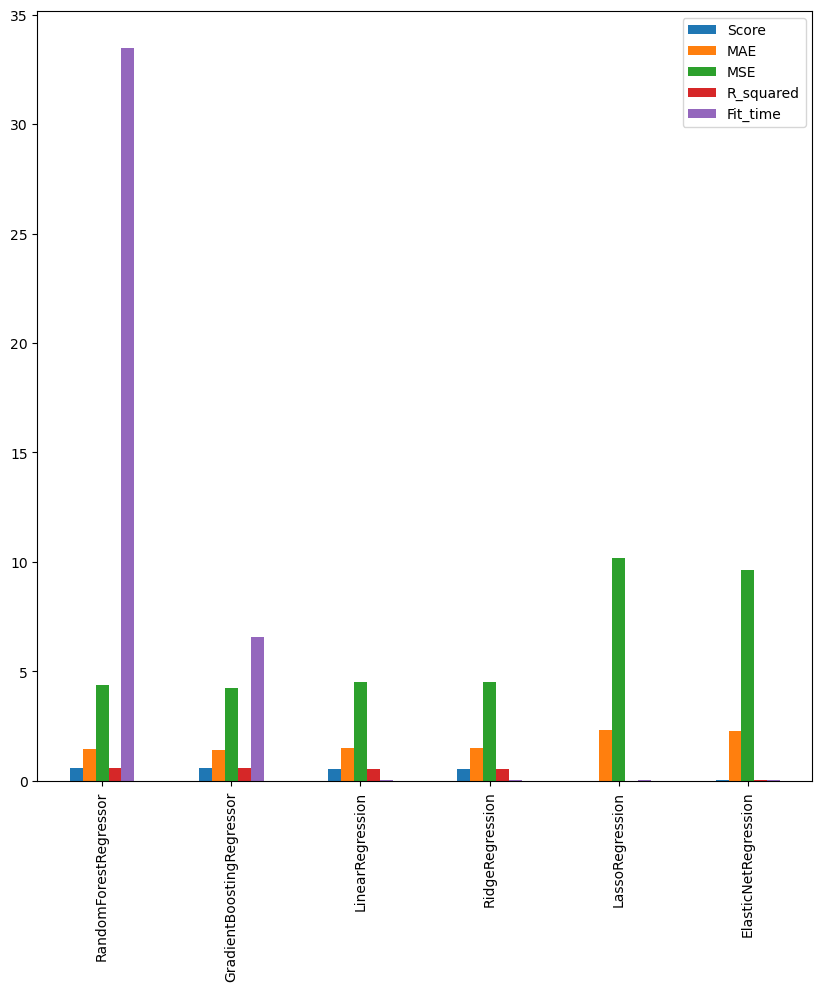

In [198]:
elastic_fit.plot.bar(figsize=(10, 10))